In [1]:
from spitfire import (ChemicalMechanismSpec, 
                      Flamelet,
                      SimpleNewtonSolver,
                      BackwardEulerS1P1Q1,
                      KennedyCarpenterS6P4Q3,
                      KvaernoS4P3Q2,
                      KennedyCarpenterS4P3Q2,
                      KennedyCarpenterS8P5Q4)
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter

In [13]:
sol = ct.Solution('h2-burke.xml', 'h2-burke')
m = ChemicalMechanismSpec.from_solution(sol)

Tair = 1200.
pressure = 101325.
zstoich = 0.1
chi_max = 1.e3
npts = 65

air = m.stream(stp_air=True)
air.TP = Tair, pressure
fuel = m.mix_fuels_for_stoich_mixture_fraction(m.stream('X', 'H2:1'), m.stream('X', 'N2:1'), zstoich, air)
fuel.TP = 300., pressure

output_dict = dict()

for method in [BackwardEulerS1P1Q1,
               KennedyCarpenterS6P4Q3,
               KvaernoS4P3Q2,
               KennedyCarpenterS4P3Q2,
               KennedyCarpenterS8P5Q4]:
    ft = Flamelet(mech_spec=m,
                  pressure=pressure,
                  oxy_stream=air,
                  fuel_stream=fuel,
                  max_dissipation_rate=chi_max,
                  grid_points=npts,
                  grid_cluster_intensity=4.,
                  initial_condition='unreacted')

    print(f'Running {method(SimpleNewtonSolver()).name}... ', end='')
    tic = perf_counter()
    output_dict[method(SimpleNewtonSolver()).name] = ft.integrate_to_steady(stepper_type=method)
    print(f'done in {perf_counter() - tic:.1f} s')

Running backward Euler... done in 22.3 s
Running Kennedy/Carpenter ESDIRK64... done in 3.7 s
Running Kvaerno ESDIRK43... done in 12.8 s
Running Kennedy/Carpenter ESDIRK43... done in 7.8 s
Running Kennedy/Carpenter ESDIRK85... done in 3.0 s


<IPython.core.display.Javascript object>


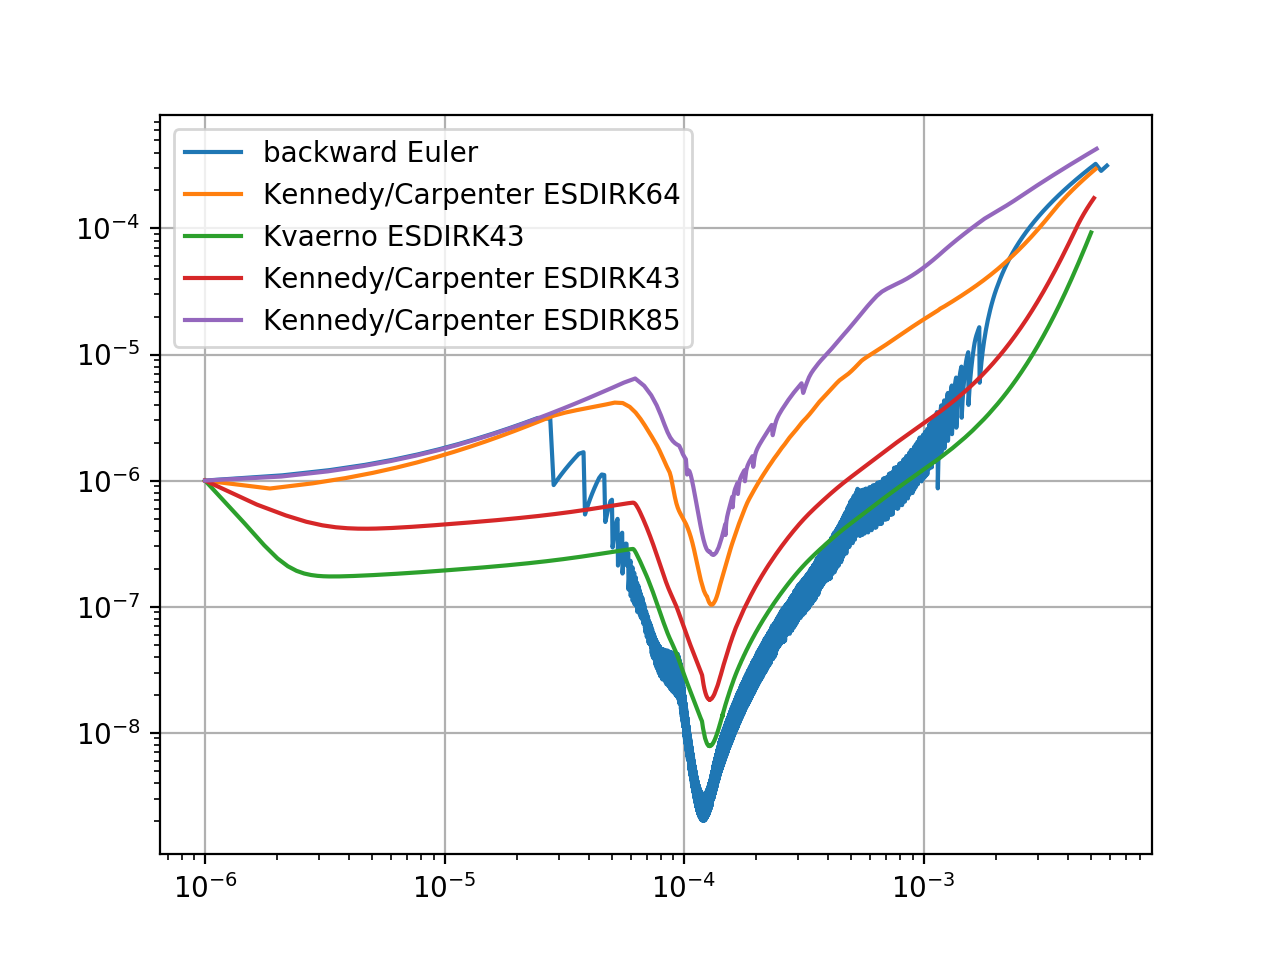

In [14]:
%matplotlib notebook
for name in output_dict:
    output = output_dict[name]
    plt.loglog(output.time_values[1:], output.time_values[1:]-output.time_values[:-1], label=name)
plt.legend(loc='best')
plt.grid()
plt.show()